### First set number of cores on machine to use and SSID number to analyse, then run all

In [1]:
# setting variables

cores = 3 # enter the number of cores to use here, in place of x
SSIDno = 30213022 # enter the SSID number to model as an int here, in place of xxxxxxxx

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.font_manager as fm
import matplotlib
import autotime
%matplotlib inline
%load_ext autotime
#import seaborn as sns
import statsmodels as stm
import statsmodels.formula.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinR
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV as RSCV
# from dask_searchcv import RandomizedSearchCV as DRSCV
# from sklearn.pipeline import Pipeline
from sklearn.metrics.scorer import make_scorer
# from sklearn.preprocessing import MinMaxScaler as MMS
from scipy import stats
from scipy.stats import randint

#from sklearn.tree import export_graphviz
#from IPython.display import Image

## 1. Data processing stage

First, select route files to input based on SSIDno to analyse

### 1a Inputting data and creating dataframe for SSIDno

In [3]:
# Read in stop_times.txt and trips.txt files from NTA data
stop_times_2012 = pd.read_csv('stop_times.txt')
trips_2012 = pd.read_csv('trips.txt')

# Merge by trip_id
merge = pd.merge(stop_times_2012, trips_2012, on='trip_id', how='outer')

# Keep only necessary columns
merge.drop(['arrival_time','departure_time','pickup_type','drop_off_type','service_id','shape_dist_traveled'], axis=1, inplace=True)

# Transform trip_id to route and stop_id to StopID
merge['route_short'] = merge['trip_id'].apply(lambda x: x[x.index('-')+1:])
merge['route_short'] = merge['route_short'].apply(lambda x: x[: x.index('-')])
merge['route_short'] = merge['route_short'].apply(lambda x: str(x).zfill(4))
merge['StopID'] = merge['stop_id'].apply(lambda x: x[-4:])

# Find StopID and the sequence of that shape_id
gb = merge.groupby(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'])
gbc = gb.count()
gbc.reset_index(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'], inplace=True)
transit_shapeID_stopID = gbc.drop(['trip_id','stop_id','route_id','trip_headsign'], axis=1)

# create list of pairs of routes and the SSIDs contained within them
ssid = []
for i in range(len(transit_shapeID_stopID.index)-1):
    temp = transit_shapeID_stopID['StopID'].iloc[i] + transit_shapeID_stopID['StopID'].iloc[i+1]
    ssid.append([ transit_shapeID_stopID['route_short'].iloc[i],temp])
    
SSIDnoStr = str(SSIDno).zfill(8)
routes = [x for x in ssid if SSIDnoStr in x[1]]
routes = [item[0] for item in routes]
routes = list(set(routes))

# Reading in the route CSV files for the required SSID

res = pd.read_csv('Route_XXXX_travel_time_csvs/Blank_Route_travel_time.csv')
route_list = routes
for r in route_list:
    df = pd.read_csv('Route_XXXX_travel_time_csvs/Route_%s_travel_time.csv' % r)
    res = pd.concat([df, res], axis=0) 

time: 4.52 s


In [4]:
# create dataframe for SSIDno

res['SSID'] = res['SSID'].astype('category')
ssid_df = res[res.SSID == SSIDno]
ssid_df.reset_index(inplace=True)
ssid_df = ssid_df.drop('index', axis=1)
ssid_df.shape

(1239, 12)

time: 36 ms


In [5]:
JPID_Count = ssid_df.JourneyPatternID.unique().shape[0]
Row_Count = ssid_df.shape[0]
print("There are", JPID_Count, "unique JPIDs traversing this segment, over the course of", Row_Count, "observations.")

There are 1 unique JPIDs traversing this segment, over the course of 1239 observations.
time: 4 ms


In [6]:
# add leading zeroes to JourneyPatternID

ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.astype('object')
ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.apply(lambda x: str(x).zfill(8))

time: 4 ms


### 1b Adding extra features and altering/dropping existing ones

In [7]:
# adding Xbuses feature - boolean feature indicating whether or not the JourneyPatternID represents an express (X) bus

ssid_df['XBuses'] = ssid_df[ssid_df["JourneyPatternID"].str.find("X") > 0].sum(axis=1) > 0
ssid_df["XBuses"].fillna(False, inplace=True)
ssid_df['XBuses'] = ssid_df['XBuses'].astype('int')

time: 6 ms


In [8]:
# adding JPID_length feature - represents the total number of stops traversed by this JourneyPatternID along its entire route

JPIDL = pd.read_csv('JPID_Length.csv')
JPIDL = JPIDL.drop('Unnamed: 0', axis=1)
ssid_df = pd.merge(left=ssid_df ,right=JPIDL, how='left', left_on='JourneyPatternID', right_on='JourneyPatternID')
ssid_df = ssid_df.dropna()
ssid_df.shape

(1239, 14)

time: 27 ms


In [9]:
# removing non-holiday-period weekends from SchoolHoliday feature to avoid multi-collinearity issues

ssid_df['SchoolHoliday'] = ssid_df['SchoolHoliday'].astype('int')
ssid_df['SchoolHoliday'] = np.where(ssid_df['TimeFrame'].isin(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)

time: 2 ms


In [10]:
# dropping unneeded columns

ssid_df = ssid_df.drop(['SourceStopID', 'DestStopID', 'VehicleJourneyID', 'JourneyPatternID', 'SSID'], axis=1)

# reordering remaining columns

ssid_df = ssid_df[['TravelTime', 'Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]

time: 5 ms


In [11]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,Day,HourFrame
0,18,0.033325,14.5,62,0,0,Tuesday,7
1,20,0.000000,16.5,62,0,0,Tuesday,10
2,43,0.000000,17.5,62,0,0,Tuesday,12
3,41,0.000000,16.5,62,0,0,Tuesday,15
4,43,0.000000,14.0,62,0,0,Tuesday,18
5,59,0.000000,15.5,62,0,0,Tuesday,9
6,59,0.000000,14.0,62,0,0,Tuesday,17
7,39,0.000000,15.0,62,0,0,Tuesday,8
8,39,0.000000,16.5,62,0,0,Tuesday,15
9,19,0.000000,16.0,62,0,0,Tuesday,19


time: 29 ms


In [12]:
# assigning appropriate datatypes where necessary

ssid_df['Day'] = ssid_df['Day'].astype('category')
ssid_df['HourFrame'] = ssid_df['HourFrame'].astype('category')
ssid_df['JPID_length'] = ssid_df['JPID_length'].astype('int')

time: 30 ms


In [13]:
# removing any constant features
# code from: https://stackoverflow.com/questions/20209600/panda-dataframe-remove-constant-column

ssid_df = ssid_df.loc[:,ssid_df.apply(pd.Series.nunique) != 1]

time: 6 ms


In [14]:
ssid_df

,TravelTime,Rain,WindSpeed,SchoolHoliday,Day,HourFrame
0,18,0.033325,14.5,0,Tuesday,7
1,20,0.000000,16.5,0,Tuesday,10
2,43,0.000000,17.5,0,Tuesday,12
3,41,0.000000,16.5,0,Tuesday,15
4,43,0.000000,14.0,0,Tuesday,18
5,59,0.000000,15.5,0,Tuesday,9
6,59,0.000000,14.0,0,Tuesday,17
7,39,0.000000,15.0,0,Tuesday,8
8,39,0.000000,16.5,0,Tuesday,15
9,19,0.000000,16.0,0,Tuesday,19


time: 22 ms


## 1c. Dropping Outliers

#### Visualising range of travel-time data first

Histiogram of values (x-axis is number of seconds)

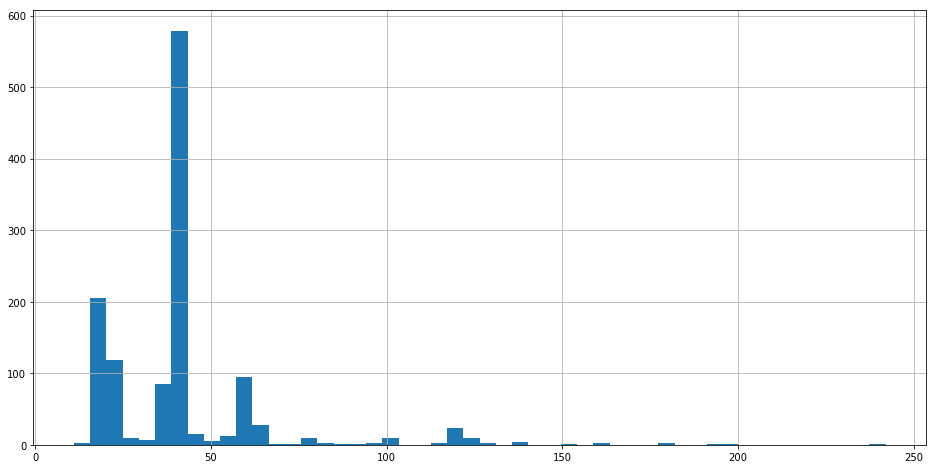

time: 222 ms


In [15]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Boxplot to check for outliers

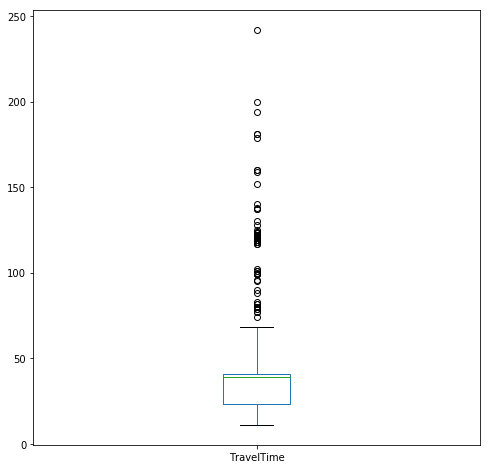

time: 123 ms


In [16]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

In [17]:
# Checking stats for TravelTime

ssid_df.TravelTime.describe()

count    1239.000000
mean       41.774011
std        24.450219
min        11.000000
25%        23.000000
50%        39.000000
75%        41.000000
max       242.000000
Name: TravelTime, dtype: float64

time: 6 ms


Dropping outliers

In [18]:
# loading table of minimum times to traverse segments at 65kmph

find_lb = pd.read_csv('use_speed_and_distance_get_outlier_bound.csv')

# extracting value for this segment, to use as lower bound for outlier removal

lb = find_lb.loc[find_lb['SSID'] == SSIDno, 'min_sec'].iloc[0]
print(lb)

16.0223390399
time: 147 ms


In [19]:
# make a copy of original df

trimssid_df = ssid_df.copy()

# Remove TravelTime upper bound outliers beyond 3 x IQR, and lowerbound below 'lb'

ub = trimssid_df.quantile(q=.75) + (3*(trimssid_df.quantile(q=.75)-trimssid_df.quantile(q=.25)))
trimssid_df['OutlierTT'] = (trimssid_df['TravelTime'] < lb) | (trimssid_df['TravelTime'] > ub['TravelTime'])

# Outlier rows counted

print("There will be", trimssid_df[(trimssid_df['OutlierTT'] == True)].shape[0], "outliers dropped.")

There will be 72 outliers dropped.
time: 12 ms


In [20]:
# dropping outliers

trimssid_df = trimssid_df[trimssid_df.OutlierTT != True]
trimssid_df.sort_values(['TravelTime'], ascending=False, inplace=True)
trimssid_df = trimssid_df.drop(['OutlierTT'], axis=1)
trimssid_df.reset_index(inplace=True)
trimssid_df = trimssid_df.drop('index', axis=1)
trimssid_df

,TravelTime,Rain,WindSpeed,SchoolHoliday,Day,HourFrame
0,95,0.000000,6.5,0,Thursday,8
1,90,0.000000,9.5,0,Thursday,8
2,88,0.000000,15.5,0,Monday,8
3,83,0.000000,9.5,0,Saturday,15
4,82,0.000000,5.0,0,Friday,8
5,82,0.000000,12.0,0,Tuesday,8
6,80,0.133301,15.0,0,Monday,9
7,80,0.000000,5.5,0,Thursday,9
8,80,0.000000,6.5,0,Wednesday,19
9,80,0.133301,5.0,0,Monday,14


time: 64 ms


In [21]:
# Create TT mean/median value variables, to use in calculating mean/median absolute percentage accuracy scores
# and for horizontal lines in the charts below to represent the mean/medium

ssid_df = trimssid_df
ssid_df_mean = ssid_df.TravelTime.mean()
ssid_df_median  = ssid_df.TravelTime.median()
ssid_df.TravelTime.describe()

# Recalculate Row_Count


Row_Count= ssid_df.shape[0]
print ("Row_Count is now", Row_Count)

Row_Count is now 1167
time: 7 ms


#### Visualising range of data after dropping outliers

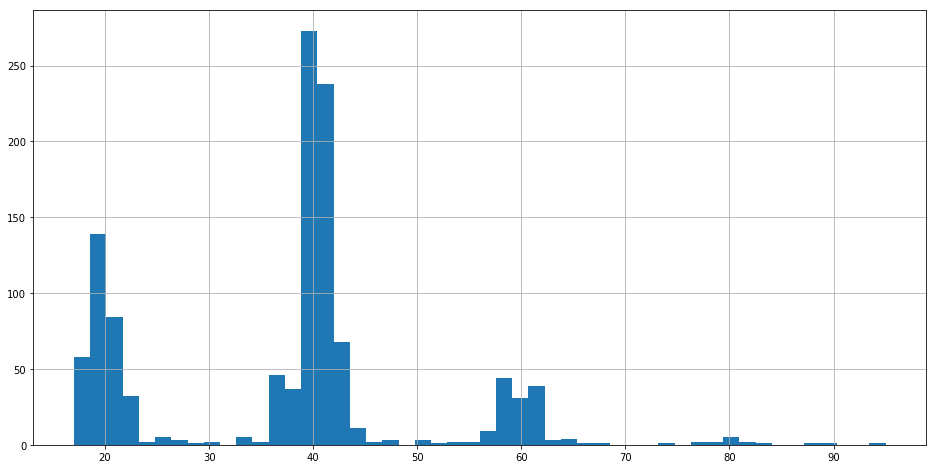

time: 216 ms


In [22]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

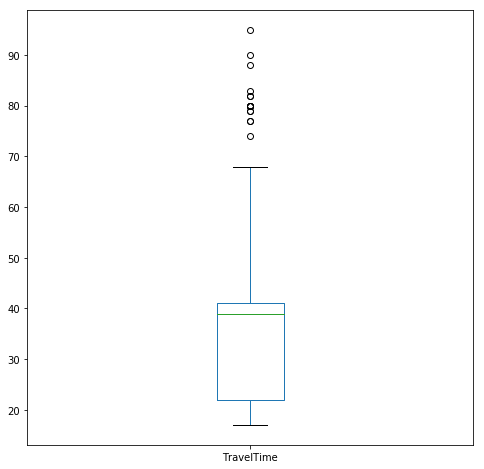

time: 123 ms


In [23]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

## 2. Visualising the data

### 2ai Bar plot for mean TravelTime per HourFrame

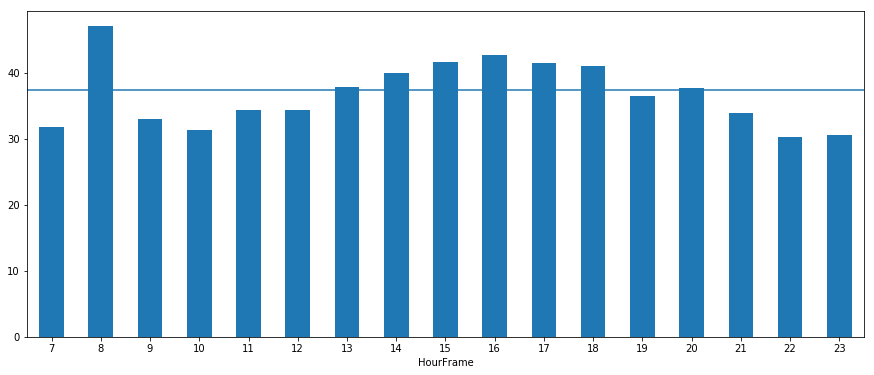

time: 179 ms


In [24]:
mean_HF = ssid_df.groupby('HourFrame')['TravelTime'].mean()
mean_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2aii Bar plot for median TravelTime per HourFrame

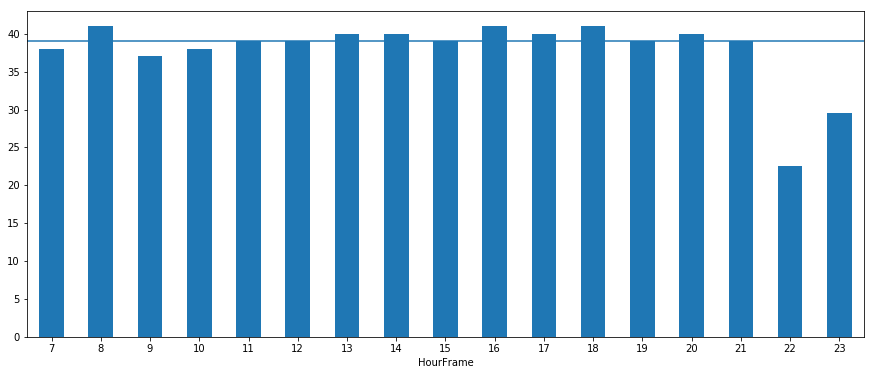

time: 187 ms


In [25]:
med_HF = ssid_df.groupby('HourFrame')['TravelTime'].median()
med_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bi Bar plot for mean TravelTime per Day

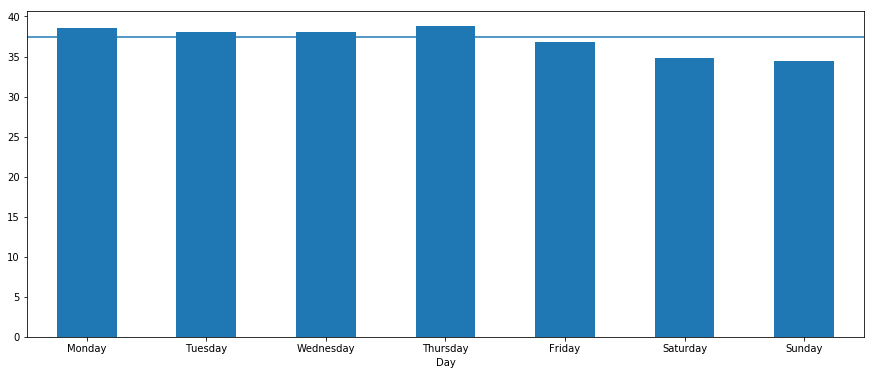

time: 151 ms


In [26]:
mean_Day = ssid_df.groupby('Day')['TravelTime'].mean()
mean_Day=mean_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

mean_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean

coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bii Bar plot for median TravelTime per HourFrame

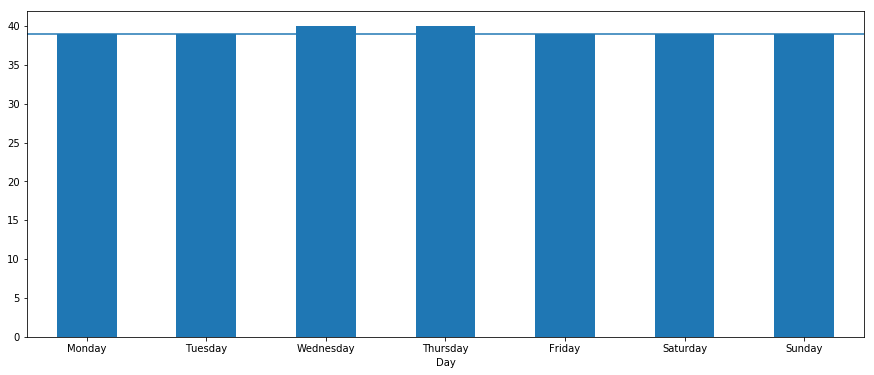

time: 191 ms


In [27]:
med_Day = ssid_df.groupby('Day')['TravelTime'].median()

med_Day=med_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
med_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation: 

### 2ci Bar plot for mean TravelTime when SchoolHoliday true/false

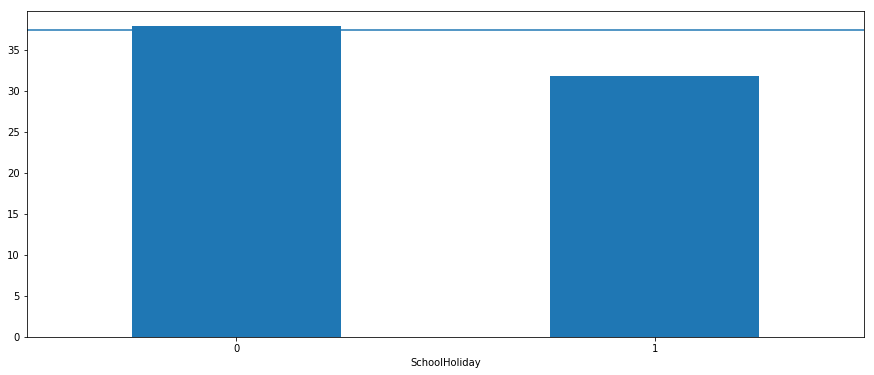

time: 138 ms


In [28]:
mean_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].mean()
mean_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2cii Bar plot for median TravelTime when SchoolHoliday true/false

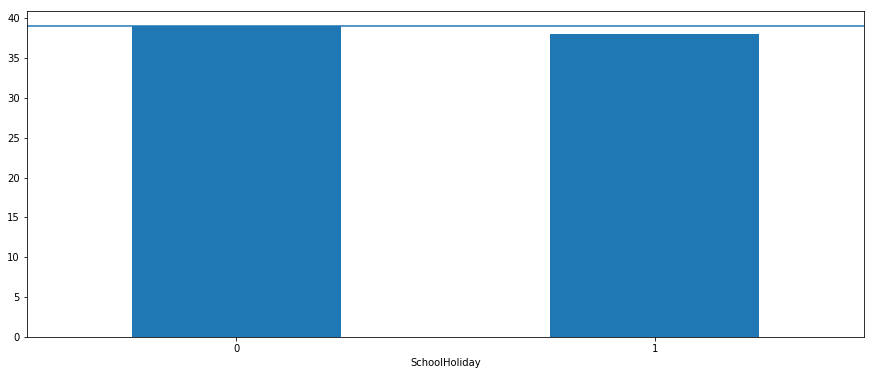

time: 140 ms


In [29]:
med_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].median()
med_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Splitting data into 70% for training and 30% for testing

## 3 Model training (Scikit-learn)

First we need to dreate dummy variables for categorical features, and split into test and training sets

### 3.1 Prepare data for modelling via Scikit-learn

In [30]:
# create dummy variables from HourFrame and Day using get_dummies
# dropping first values to avoid multicollinearity (Day = Friday, Hour = 0 or 6 or 7, depending on SSID)

Day_dummies = pd.get_dummies(ssid_df.Day, prefix='Day', drop_first=True)
HF_dummies = pd.get_dummies(ssid_df.HourFrame, prefix='HF', drop_first=True)

# concatenate the dummy variable columns onto the original DataFrame and drop the original features
ssid_df = pd.concat([ssid_df, HF_dummies, Day_dummies], axis=1)
ssid_df = ssid_df.drop(['HourFrame', 'Day'], axis=1)
ssid_df

,TravelTime,Rain,WindSpeed,SchoolHoliday,HF_8,HF_9,HF_10,HF_11,HF_12,HF_13,...,HF_20,HF_21,HF_22,HF_23,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,95,0.000000,6.5,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,90,0.000000,9.5,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,88,0.000000,15.5,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,83,0.000000,9.5,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,82,0.000000,5.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,82,0.000000,12.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,80,0.133301,15.0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,80,0.000000,5.5,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,80,0.000000,6.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,80,0.133301,5.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


time: 55 ms


In [31]:
# prepare a list containing all remaining features bar the target
pred_features = list(ssid_df)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'SchoolHoliday', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 2 ms


In [32]:
# prepare target/predictive feature variables for use in scikit-learn modelling

X = ssid_df[pred_features]
y = ssid_df['TravelTime']

time: 6 ms


In [33]:
# split the data into training portion (70%) and final testing potion (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 38)

time: 3 ms


### 3.2a Gradient Boosting Regression model - training - default parameters

In [34]:
gbr = GBR()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 55 ms


In [35]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.329176248122
Rain 	 0.137550891291
HF_8 	 0.0671523339148
HF_10 	 0.0374812996116
Day_Wednesday 	 0.0329523435117
HF_17 	 0.0328753211513
HF_16 	 0.0325992523938
SchoolHoliday 	 0.0290542279298
Day_Monday 	 0.0281936775985
Day_Sunday 	 0.0278132200108
Day_Saturday 	 0.0277259351364
HF_22 	 0.027550076012
HF_15 	 0.0271066654488
HF_18 	 0.0221165397935
Day_Thursday 	 0.0219717292346
Day_Tuesday 	 0.0218437178713
HF_23 	 0.0194074603881
HF_14 	 0.017812455355
HF_20 	 0.0136448619442
HF_9 	 0.0111055130098
HF_11 	 0.0107736361646
HF_21 	 0.0104144738496
HF_19 	 0.00669226389816
HF_13 	 0.00405002512839
HF_12 	 0.00293583122995
time: 64 ms


In [36]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsq)

The R-squared value of the Gradient Boosting Regression model is 0.330224314726
time: 3 ms


In [37]:
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 8.37837422529
The mean absolute percentage error is 22.382480361
time: 3 ms


In [38]:
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 6.58351926485
The median absolute percentage error is 16.8808186278
time: 4 ms


### 3.2b Gradient Boosting Regression model - - testing - default parameters

In [39]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsqa)

The R-squared value of the Gradient Boosting Regression model is 0.0495379305621
time: 5 ms


In [40]:
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 10.1427216678
The mean absolute percentage error is 27.0958616115
time: 4 ms


In [41]:
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 7.89099542951
The median absolute percentage error is 20.2333216141
time: 2 ms


## 4 Parameter tuning with RandomizedSearchCV

### 4a Gradient Boosted Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [182]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(50, 5000),
            'max_depth': stats.randint(4, 9),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.0001, 0.6)}

time: 6 ms


In [183]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=100, cv=5, n_jobs=cores, scoring=make_scorer(metrics.mean_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000026E1FBE0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000026E1FDA0>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000026E1FEF0>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000026E1F080>, 'learning_rate': <scipy.stats._distn_in

time: 4min 15s


In [184]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.23746402980268269, 'max_depth': 6, 'min_samples_leaf': 64, 'min_samples_split': 693, 'n_estimators': 60}
time: 1e+03 µs


In [189]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

Best MdAE found is 9.77398142275
Best MdAPE found is 25.061%
time: 3 ms


In [190]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,-9.771044,-9.773981,60,6,64,693,0.237464,0.0194,0.0002
1,2,-9.771044,-9.773981,1442,6,11,969,0.0218596,0.4754,0.0008
2,3,-9.771044,-9.773981,3289,6,84,923,0.0240708,1.1144,0.0018
3,4,-9.771044,-9.773981,3157,6,80,970,0.0263252,1.1096,0.0016
4,5,-9.771044,-9.773981,4599,6,70,666,0.0343923,1.4952,0.0022
5,6,-9.771044,-9.773981,826,4,19,964,0.0531462,0.2612,0.0006
6,6,-9.771044,-9.773981,1409,8,9,821,0.0534229,0.4330,0.0010
7,8,-9.771044,-9.773981,3477,4,29,982,0.0893762,1.0626,0.0014
8,8,-9.771044,-9.773981,4062,6,36,899,0.0919745,1.2544,0.0018
9,8,-9.771044,-9.773981,2643,7,27,922,0.0918349,0.8674,0.0014


time: 41 ms


In [196]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", gbr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 6.22888594575
MdAPE of best model on the test set is 15.972%
time: 4 ms


In [197]:
gbr_maea = metrics.mean_absolute_error(y_test, gbr_test_pred)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 9.90062234667
The mean absolute percentage error is 26.449103284
time: 2 ms


In [195]:
metrics.r2_score(y_test, gbr_test_pred)

0.0075456345205304753

time: 3 ms


In [198]:
print("Row_Count is", Row_Count, "and JPID_Count is", JPID_Count)

Row_Count is 1167 and JPID_Count is 1
time: 1 ms


Now trying with fine-tuned parameters

In [200]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(20, 500),
            'max_depth': stats.randint(6, 9),
            'min_samples_leaf': stats.randint(50, 150),
            'min_samples_split': stats.randint(800, 2000),
            'learning_rate': stats.uniform(0.0001, 0.1)}

gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=100, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000270AA748>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000270AA908>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000270AAA58>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000270AABE0>, 'learning_rate': <scipy.stats._distn_in

time: 16.9 s


In [201]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

Best MdAE found is 2.64651396299
Best MdAPE found is 6.786%
time: 2 ms


In [202]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,-2.185077,-2.646514,148,6,108,1208,0.000668105,0.0460,0.0006
1,2,-2.234475,-2.685614,43,6,56,1953,0.0029491,0.0178,0.0014
2,3,-2.293555,-2.732374,131,6,96,1604,0.00123293,0.0516,0.0004
3,4,-2.600501,-3.000039,232,6,82,1220,0.00156372,0.0720,0.0006
4,5,-2.839603,-3.239151,54,8,115,1209,0.0102214,0.0182,0.0004
5,6,-2.920818,-3.320370,431,6,86,1337,0.0014598,0.1372,0.0008
6,7,-3.009120,-3.408676,222,6,107,1841,0.00322975,0.0694,0.0004
7,8,-3.114872,-3.514432,277,6,96,1453,0.00301431,0.0914,0.0004
8,9,-3.213514,-3.613078,65,7,140,830,0.0146794,0.0222,0.0004
9,10,-3.283915,-3.683482,183,7,125,1032,0.00578565,0.0572,0.0008


time: 44 ms


In [203]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", gbr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 3.18507412451
MdAPE of best model on the test set is 8.167%
time: 6 ms


In [216]:
metrics.r2_score(y_test, gbr_test_pred)

-0.011683503793483707

time: 2 ms


Repeating with Subsample parameters tested at below default (1)

In [204]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(20, 500),
            'max_depth': stats.randint(6, 9),
            'min_samples_leaf': stats.randint(50, 150),
            'min_samples_split': stats.randint(800, 2000),
            'learning_rate': stats.uniform(0.0001, 0.1),
            'subsample': stats.uniform(0.25, 0.75)}

gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=100, cv=5, n_jobs=cores, scoring=make_scorer(metrics.mean_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000026E97BE0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000026E97D30>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000026E97E80>, 'm...026E97588>, 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000026E88B00>},
          pre_dispatch='2*n_j

time: 20.8 s


In [205]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

Best MdAE found is 9.16171347437
Best MdAPE found is 23.492%
time: 3 ms


In [206]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'param_subsample', 'mean_fit_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,param_subsample,mean_fit_time
0,1,-9.161713,87,8,99,1087,0.000376486,0.569341,0.0440
1,2,-9.258299,20,6,50,1319,0.0106894,0.841092,0.0112
2,3,-9.515951,68,7,77,1624,0.0135809,0.53637,0.0322
3,4,-9.517793,365,8,148,1883,0.002616,0.341945,0.1620
4,5,-9.534303,398,6,67,1784,0.00252176,0.631943,0.2382
5,6,-9.561536,66,7,81,1579,0.0168328,0.409905,0.0304
6,7,-9.565217,137,7,88,1912,0.00824522,0.890329,0.0594
7,8,-9.578416,73,6,101,986,0.0160811,0.866607,0.0396
8,9,-9.590826,79,8,110,1767,0.0158945,0.707809,0.0360
9,10,-9.606708,39,8,101,1776,0.0339242,0.771426,0.0184


time: 40 ms


In [207]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", gbr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 3.06412178116
MdAPE of best model on the test set is 7.857%
time: 5 ms


Testing specific values, as dervied from analysis of above results

In [208]:
gbr1 = GBR(loss='huber', n_estimators=100, max_depth=20, min_samples_leaf=15, min_samples_split=50, learning_rate=0.05, subsample=0.5)
gbr1.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=20,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=15,
             min_samples_split=50, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=0.5, verbose=0, warm_start=False)

time: 215 ms


In [209]:
indices = np.argsort(gbr1.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr1.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.377580507522
Rain 	 0.103387496851
HF_8 	 0.0644814836511
SchoolHoliday 	 0.0436604616692
Day_Wednesday 	 0.0348493738096
HF_18 	 0.0308072444875
Day_Tuesday 	 0.0304658980117
HF_16 	 0.0289601600495
HF_17 	 0.0265116026591
Day_Thursday 	 0.0259298047271
HF_15 	 0.0236842302154
Day_Saturday 	 0.0235064829099
Day_Monday 	 0.022603067427
HF_14 	 0.021634525932
HF_19 	 0.0202787856285
HF_10 	 0.019969608312
HF_23 	 0.0184318324199
Day_Sunday 	 0.0184058146993
HF_9 	 0.0180479144694
HF_22 	 0.015065275361
HF_21 	 0.0117163263248
HF_13 	 0.00822959120676
HF_20 	 0.00742311768762
HF_12 	 0.00361814043399
HF_11 	 0.000751253535096
time: 64 ms


In [210]:
gbr1_pred = gbr1.predict(X_train)
gbr1_rsq = metrics.r2_score(y_train, gbr1_pred)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr1_rsq)

The R-squared value of the Gradient Boosting Regression model is 0.272208471678
time: 5 ms


In [211]:
gbr1_mae = metrics.mean_absolute_error(y_train, gbr1_pred)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr1_mae)
print ("The mean absolute percentage error is", (((gbr1_mae)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 8.80295465351
The mean absolute percentage error is 23.5167294219
time: 2 ms


In [212]:
gbr1_mdae = metrics.median_absolute_error(y_train, gbr1_pred)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr1_mdae)
print ("The median absolute percentage error is", (((gbr1_mdae)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 7.45510660354
The median absolute percentage error is 19.1156579578
time: 8 ms


### 3.2b Gradient Boosting Regression model - - testing - default parameters

In [213]:
gbr1_preda = gbr1.predict(X_test)
gbr1_rsqa = metrics.r2_score(y_test, gbr1_preda)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr1_rsqa)

The R-squared value of the Gradient Boosting Regression model is 0.0597662026558
time: 5 ms


In [214]:
gbr1_maea = metrics.mean_absolute_error(y_test, gbr1_preda)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr1_maea)
print ("The mean absolute percentage error is", (((gbr1_maea)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 10.3224844258
The mean absolute percentage error is 27.5760903877
time: 2 ms


In [215]:
gbr1_mdaea = metrics.median_absolute_error(y_test, gbr1_preda)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr1_mdaea)
print ("The median absolute percentage error is", (((gbr1_mdaea)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 8.36421735257
The median absolute percentage error is 21.4467111604
time: 3 ms
